In [1]:
%matplotlib notebook

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
import time
from scipy.optimize import minimize
from climin.util import optimizer
import theano
import theano.tensor as T
from itertools import izip

gnumpy: failed to import cudamat. Using npmat instead. No GPU will be used.


In [3]:
from schlichtanders.myoptimizers import batch
from schlichtanders.myfunctools import Compose

In [4]:
from theano_models import total_size, as_tensor_variable, reparameterize_map, softplus, softplus_inv, squareplus, squareplus_inv

from theano_models.postmaps import scipy_postmap, climin_postmap, flat_numericalize_postmap, flatten_parameters

import theano_models.probabilistic_models as pm
import theano_models.deterministic_models as dm

# Deterministic Model - one dimensional

## model

In [5]:
model = dm.RadialTransform()
model

{ 'inputs': [f_inputs],
  'inverse_inputs': [inverse_inputs],
  'inverse_outputs': inverse_outputs,
  'norm_det': Elemwise{mul,no_inplace}.0,
  'outputs': f_outputs,
  'parameters': [z0],
  'parameters_positive': [alpha, beta+alpha]}

TODO softplus gives immediate precision loss, while e.g. squarepos works like a charm

    # model.map('parameters_positive', reparameterize_map(softplus, softplus_inv), 'parameters')

In [6]:
model.map('parameters_positive', reparameterize_map(squareplus, squareplus_inv), 'parameters')
model.add_postmap(Compose(flat_numericalize_postmap, flatten_parameters))
model

{ 'inputs': [f_inputs],
  'inverse_inputs': [inverse_inputs],
  'inverse_outputs': inverse_outputs,
  'norm_det': Elemwise{mul,no_inplace}.0,
  'outputs': f_outputs,
  'parameters': [z0, alpha_copy_squareplus, beta+alpha_copy_squareplus],
  'parameters_positive': [alpha_reparam, beta+alpha_reparam]}

## target

In [7]:
target = dm.RadialTransform(init_alpha=1, init_beta=20, init_z0=[3])

In [8]:
f_target = target.function()
example_target = [7]
f_target(example_target)  # caution, needs vector not scalar input

array([ 23.])

In [9]:
N = 40
xs = np.linspace(-10, 10, N)[:, np.newaxis]
xs[:7]

array([[-10.        ],
       [ -9.48717949],
       [ -8.97435897],
       [ -8.46153846],
       [ -7.94871795],
       [ -7.43589744],
       [ -6.92307692]])

In [10]:
ys = np.array([f_target(x) for x in xs])
ys[:7]

array([[-28.57142857],
       [-28.00428975],
       [-27.432857  ],
       [-26.85660019],
       [-26.27489821],
       [-25.68701851],
       [-25.09209101]])

## visualization

In [11]:
def plot_fit(fig, ax, givens={}, time_delay=0.1):
    ax.clear() # interactive
    # target data:
    ax.plot(xs, ys, 'k:')
    
    # model:
    f_model = model.function(givens=givens)
    model_ys = np.array([f_model(x) for x in xs])
    ax.plot(xs, model_ys, 'r')
    
    fig.canvas.draw()
    time.sleep(time_delay)

<IPython.core.display.Javascript object>


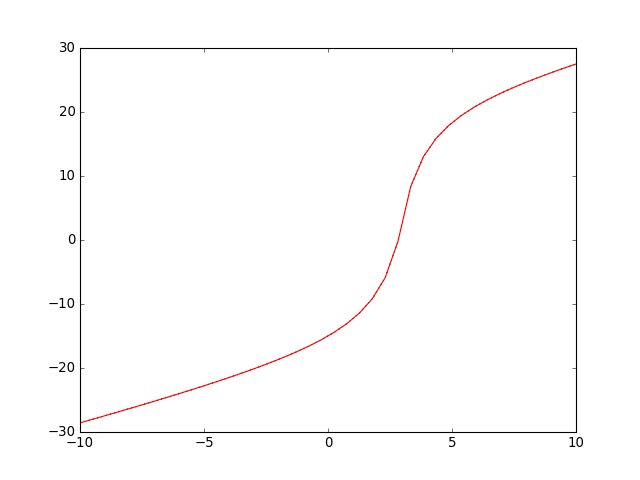

In [12]:
fig, ax = plt.subplots()
plot_fit(fig, ax)

## fit

In [13]:
scipy_kwargs = scipy_postmap(model.postmap(wrapper=batch, initial_inputs=[example_target]))
scipy_kwargs

{'fun': <function schlichtanders.myoptimizers.f_batch>,
 'hess': <function schlichtanders.myoptimizers.f_batch>,
 'jac': <function schlichtanders.myoptimizers.f_batch>,
 'x0': array([ 0.        ,  0.99995   ,  1.41417821])}

In [14]:
fit = minimize(
    args=(ys,xs),
#     method="CG",
    method="Newton-CG",
    options={'maxiter':100, 'disp':True},
    callback=lambda xs: plot_fit(fig, ax, {model['parameters_flat'][0]:xs}),
    **scipy_kwargs
); fit

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 25
         Hessian evaluations: 12


     fun: 2.51054983086587e-28
     jac: array([ -3.94380766e-07,   2.01949302e-07,  -2.51502061e-06])
 message: 'Optimization terminated successfully.'
    nfev: 14
    nhev: 12
     nit: 12
    njev: 25
  status: 0
 success: True
       x: array([ 3.        , -0.99995   ,  4.58256478])

Fix fitted parameters into model.

We need to further build a givens dictionary supply the input-info which usually is given when used as theano.function(model['inputs'], model['outputs']).

In [15]:
model['parameters_flat'] = [fit.x]
givens = dict(izip(model['inputs'], [example_target]))

In [16]:
[(p.name, p.eval(givens)) for p in model['parameters_positive']]

[('alpha_reparam', array(1.0000000000000007)),
 ('beta+alpha_reparam', array(21.000000000000007))]

In [17]:
[(p.name, p.eval(givens)) for p in model['parameters']]

[('z0_flat', array([ 3.])),
 ('alpha_copy_squareplus_flat', array(-0.9999499987499378)),
 ('beta+alpha_copy_squareplus_flat', array(4.58256478404834))]

# two dimensions

## model

In [18]:
model2d = dm.RadialTransform()
model2d.add_postmap(Compose(flat_numericalize_postmap, flatten_parameters))
model2d

{ 'inputs': [f_inputs],
  'inverse_inputs': [inverse_inputs],
  'inverse_outputs': inverse_outputs,
  'norm_det': Elemwise{mul,no_inplace}.0,
  'outputs': f_outputs,
  'parameters': [z0],
  'parameters_positive': [alpha, beta+alpha]}

In [19]:
model2d.map('parameters_positive', reparameterize_map(squareplus, squareplus_inv), 'parameters')
model2d

{ 'inputs': [f_inputs],
  'inverse_inputs': [inverse_inputs],
  'inverse_outputs': inverse_outputs,
  'norm_det': Elemwise{mul,no_inplace}.0,
  'outputs': f_outputs,
  'parameters': [z0, alpha_copy_squareplus, beta+alpha_copy_squareplus],
  'parameters_positive': [alpha_reparam, beta+alpha_reparam]}

## target

In [20]:
target2d = dm.RadialTransform(init_alpha=1, init_beta=5, init_z0=[3, 1])
# target2d = dm.RadialTransform(init_alpha=50, init_beta=-40, init_z0=[3, 1])

In [21]:
f_target2d = target2d.function()
example_target2d = [7, 4]
f_target2d(example_target2d)  # caution, needs vector not scalar input

array([ 10.33333333,   6.5       ])

In [22]:
N2d = 10
_xs = np.linspace(-10, 10, N2d)
X1, X2 = np.meshgrid(_xs, _xs)
xs2d = np.c_[X1.flat, X2.flat]
xs2d[:5]

array([[-10.        , -10.        ],
       [ -7.77777778, -10.        ],
       [ -5.55555556, -10.        ],
       [ -3.33333333, -10.        ],
       [ -1.11111111, -10.        ]])

In [23]:
ys2d = np.array([f_target2d(x) for x in xs2d])
ys2d[:5]

array([[-13.60522531, -13.05057526],
       [-11.06368242, -13.35365526],
       [ -8.41972766, -13.68250699],
       [ -5.64595806, -14.01666399],
       [ -2.72417999, -14.31604917]])

## visualization

In [24]:
diff2d = ys2d - xs2d
quiver_kwargs = dict(scale=1, angles='xy', scale_units='xy', width=0.003)

def plot_fit2d(fig, ax, givens={}, time_delay=0.1, expand_factor=0.4):
    ax.clear()
    
    # target data:
    ax.quiver(xs2d[:,0], xs2d[:,1], diff2d[:,0], diff2d[:,1], hatch='***', facecolor='none', color="k", **quiver_kwargs)
    
    # model:
    f_model2d = model2d.function(givens=givens)
    m_ys2d = np.array([f_model2d(x) for x in xs2d])
    m_diff2d = m_ys2d - xs2d
    ax.quiver(xs2d[:,0], xs2d[:,1], m_diff2d[:,0], m_diff2d[:,1], color="r", **quiver_kwargs)

    # ax.autoscale()  # does not work with arrows, do it manually:
    l, r, b, t = ax.axis()
    dx, dy = r - l, t - b
    ax.axis([l - expand_factor * dx, r + expand_factor * dx, b - expand_factor * dy, t + expand_factor * dy])
    
    fig.canvas.draw()
    time.sleep(time_delay)

<IPython.core.display.Javascript object>


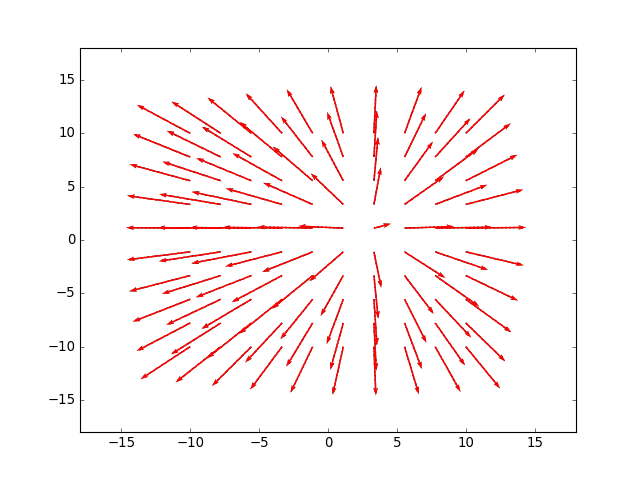

In [25]:
fig, ax = plt.subplots()
plot_fit2d(fig, ax)

## fit

In [26]:
scipy_kwargs2d = scipy_postmap(model2d.postmap(wrapper=batch, initial_inputs=[example_target2d]))
scipy_kwargs2d

{'fun': <function schlichtanders.myoptimizers.f_batch>,
 'hess': <function schlichtanders.myoptimizers.f_batch>,
 'jac': <function schlichtanders.myoptimizers.f_batch>,
 'x0': array([ 0.        ,  0.        ,  0.99995   ,  1.41417821])}

In [28]:
fit = minimize(
    args=(ys2d,xs2d),
#     method="CG",
    method="Newton-CG",
    options={'maxiter':100, 'disp':True},
    callback=lambda xs: plot_fit2d(fig, ax, {model2d['parameters_flat'][0]:xs}),
    **scipy_kwargs2d
); fit

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 13
         Function evaluations: 16
         Gradient evaluations: 28
         Hessian evaluations: 13


     fun: 7.070044445578721e-21
     jac: array([ -1.62024842e-04,   4.87423924e-05,   3.46724638e-06,
        -4.52915930e-06])
 message: 'Optimization terminated successfully.'
    nfev: 16
    nhev: 13
     nit: 13
    njev: 28
  status: 0
 success: True
       x: array([ 3.        ,  1.        ,  0.99995   ,  2.44946933])

# Probabilistic Normalizing Flow

Only the combination with gaussian base function is shown. The uniform base function has the disadvantage of not being differentiable (not yet supported).

## model

In [29]:
base_model = pm.DiagGauss(output_size=2)
# CAUTION, this transform cannot be reused elsewhere, as it is merged into normalizing flow
# its references point always to the current substitution
transform_model = dm.RadialTransform()

In [30]:
model = pm.NormalizingFlow(transform_model, base_model)
m_sampler = model.function()
m_sampler()

array([-0.46269248, -1.88442099])

In [32]:
model

{ 'RV': f_outputs,
  'inputs': [],
  'logP': <function logP at 0x7f088deadb18>,
  'outputs': f_outputs,
  'parameters': [mean, z0]}

## target

In [31]:
base_target = pm.DiagGauss(init_mean=[5,5], init_var=(10,5))
transform_target = dm.RadialTransform(init_z0=[5,5], init_beta=30, init_alpha=3)

In [ ]:
target = pm.NormalizingFlow(transform_target, base_target)
t_sampler = target.function()
t_sampler()

In [ ]:
n_samples = 2000
targets = np.array([t_sampler() for _ in xrange(n_samples)])

## visualization

In [ ]:
scatter_kwargs = dict(edgecolors="face", alpha=0.01, s=5000)
outer = dict(i=0)
def plot_fit(fig, ax, time_delay=0.1):
    outer['i'] += 1
    ax.clear()
    
    # targets
    ax.plot(targets[:,0], targets[:,1], 'k.')
#     ax.scatter(targets[:,0], targets[:,1], c='k', **scatter_kwargs)
    # model
    m_samples = np.array([m_sampler() for _ in xrange(n_samples)])
    ax.scatter(m_samples[:,0], m_samples[:,1], c='r',**scatter_kwargs)

    fig.canvas.draw()
    if time_delay is not None:
        time.sleep(time_delay)

In [ ]:
fig, ax = plt.subplots()
plot_fit(fig, ax)

## fit

In [ ]:
myoptimizer = opt.ScipyOptimizer(batch)
# CAUTION: scipy args needs to be tuple in order to work as expected!
myoptimizer.optimize(
    model, args=(targets,),
#     method='CG',
#     method="Newton-CG",
#     method="Nelder-Mead",
    options={'maxiter':10000, 'disp':True},
    callback=lambda x: plot_fit(fig, ax, time_delay=0.001)
)

In [ ]:
alpha = transform_model.alpha_from_Alpha(transform_model._Alpha.get_value(), module=np)
beta = transform_model.beta_from_Beta(alpha, transform_model._Beta.get_value(), module=np)
print alpha, beta